# Tag 1 - Einführung in Machine Learning
### Was wir heute lernen werden
In den Übungen in diesem Notebook werden wir die Grundlagen von Machine Learning, insbesondere Deep Learning, mit der Library PyTorch lernen. Dazu verwenden wir einen klassischen ML Use-Case: Klassifizierung von Bildern. Im Detail werden wir die folgenden Punkte behandeln:
- Daten & Pre-Processing:
  - Wie werden Bild-Daten für ML Zwecke repräsentiert?
  - Wie laden wir unsere Daten effizient, und wie teilen wir sie in Trainings-/Validierungs-/Test-Daten auf?
  - Welche Pre-Processing Schritte müssen wir anwenden, um unsere Daten nutzen zu können?
- Model-Konstruktion:
  - Warum sind Convolutional Neural Networks (CNNs) eine beliebte Architektur für Bilder als Input-Daten?
  - Wie ist ein Convolutional Neural Network (CNN) aufgebaut? Welcher Layer tut was? 
  - Wie konstruiere ich mein eigenes CNN?
- Training:
  - Was passiert beim Training eines Neural Networks? Was ist Back-Propagation? 
  - Wie ist der Trainings-Loop eines ML Models aufgebaut? 
  - Was ist eine Loss-Function? Wofür brauche ich einen Optimizer?
  - Wie bestimme ich, ob sich mein Model durch das Training verbessert?
- Overfitting:
  - Was ist Overfitting? Woran erkenne ich es?
  - Welche Möglichkeiten habe ich, um damit umzugehen (Data Augmentation, Regularization, etc.)?
- Transfer-Learning
  - Wie kann ich bereits trainierte Models nutzen, um schneller zu einem Model für meinen Use-Case zu kommen?
- Inferenz:
  - Wie nutze ich mein trainiertes Model?

### Was wir heute bauen werden
In der heutigen Einheit bauen wir einen Classifier, der zwischen zwei Klassen unterscheiden kann: Katzen und Hunde! Am Ende werden wir ein kleines Interface bauen, in dem du Bilder deines eigenen Haustiers hochladen kannst, um zu testen, ob der Classifier sie richtig einordnen kann:  

## Daten & Pre-Processing
### Datensatz

Bevor wir überhaupt daran denken, unser Model zu trainieren, brauchen wir die Daten mit dem wir es trainieren können. Für unseren Zweck gibt es den [Cats-vs-Dogs Datensatz](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset), der aus dem Bilder-Korpus für Microsofts Asirra CAPTCHAs entstanden ist: https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/. Füge den Datensatz deinem Jupyter Notebook hinzu, in dem du in der rechten Seitenleiste unter dem "Data"-Reiter auf "Add Data" klickst: 

<img src="https://i.imgur.com/mef3920.png" style="width: 300px; height: auto" title="source: imgur.com" />

Suche hier nach "Cats-vs-Dogs" und füge den Datensatz mit einem Klick auf den "+"-Button deinem Environment hinzu: 

<img src="https://i.imgur.com/MVd3OV1.png" style="width: 300px; height: auto" title="source: imgur.com" />

In der Seitenleiste kannst du jetzt die Struktur des heruntergeladenen Datensatzes begutachten: Wir haben einen Ordner `PetImages`, in dem zwei Ordner `Cats` und `Dogs` liegen. Jeder dieser Ordner enthält 12.500 `.jpg`-Bilder, die jeweils Katzen oder Hunde zeigen. Im Datei-System deines Kaggle-Notebooks wurde der Datensatz unter `/kaggle/input/microsoft-catsvsdogs-dataset` abgelegt.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Das Laden von Datensätzen über diesen Mechanismus ist eine Einschränkung von Kaggle, da wir von Kaggle keinen uneingeschränkten Zugriff auf das Environment bekommen, in dem unser Jupyter-Notebook läuft. Beim Entwickeln auf deinem eigenen Rechner hättest du selbstverständlich mehr Möglichkeiten, um Daten zu laden: je nach Art der Daten für den aktuellen Use-Case stehen von Downloads von File-Servern über Verteilung mittels Torrents bis zu Exports von Datenbanken viele Wege offen.

### Laden des Datensatzes
PyTorch abstrahiert einen Datensatz mit der `Dataset`-Klasse (https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), die nur 2 Methoden besitzt: `__len__()` gibt die Anzahl der Samples im Datensatz zurück, während `__getitem__()` das Sample zu einem bestimmten Index liefert. Ein Sample besteht hierbei immer aus den Features (also unseren Input-Daten, hier ein Bild) und dem Label (also das, was unser Model als Output produzieren soll, hier `0` oder `1`, je nachdem ob das Input-Bild eine Katze oder einen Hund zeigt). Per Konvention akzeptieren `Dataset`s zwei Constructor-Arguments `transform` und `target_transform`. Mit diesen können wir Funktionen übergeben, die die Features oder das Label verändern, bevor sie von einem Aufruf von `__getitem__()` zurückgegeben werden. 

Laden wir also unseren Datensatz. Der Aufbau unseres Datensatzes eignet sich perfekt für den Einsatz der `ImageFolder` Klasse aus der `torchvision`-Library, einer Sub-Klasse von `Dataset`: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html. Da diese Bilder standardmäßig als Instanzen der `Image`-Klasse aus der `pillow`-Library lädt (https://pillow.readthedocs.io/en/stable/), übergeben wir die `ToTensor()` Funktion als `transform`, damit wir die Bilddaten von unserem `Dataset` direkt als PyTorch-Tensors geliefert bekommen.

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=ToTensor())

Sehen wir uns unser `Dataset` an. Wie erwartet enthält es insgesamt 30.000 Samples:

In [2]:
catsvsdogs_dataset.__len__()

25000

Wenn wir uns mit `__getitem__()` ein bestimmtes Sample zurückgeben lassen, erhalten wir ein Tuple mit 2 Einträgen, die Features (also das Input-Bild) und das Label:

In [3]:
sample_id = 5
sample = catsvsdogs_dataset.__getitem__(sample_id)
print(f"Image Shape: {sample[0].shape}")
print(f"Image Data: {sample[0]}")
print(f"Label: {sample[1]}")

Image Shape: torch.Size([3, 360, 431])
Image Data: tensor([[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.3255, 0.3059, 0.3451,  ..., 0.0863, 0.0941, 0.0902],
         [0.3608, 0.4314, 0.4157,  ..., 0.0667, 0.0667, 0.0667],
         [0.4510, 0.3608, 0.2667,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.0824, 0.0784, 0.0863,  ..., 0.0314, 0.0314, 0.0353],
         [0.1176, 0.1647, 0.1569,  ..., 0.0314, 0.0314, 0.0314],
         [0.1804, 0.1176, 0.0157,  ..., 0.0314, 0.0314, 0.0314]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
       

Das Label ist wie erwartet `0` oder `1` je nach Klasse des Bildes. Das Bild selbst wird uns als 3-dimensionaler PyTorch Tensor zurückgegeben. Diese Dimensionen beschreiben $C \times H \times W$, wobei $H$ und $W$ die Höhe bzw. Breite des Bildes in Pixeln repräsentieren, während $C$ die Anzahl der Farbkanäle darstellt. Für schwarz-weiße Bilder ist $C=1$, während Farbbilder 3 Farbkanäle haben ($C=3$), gewöhnlich in der Reihenfolge Red-Green-Blue (RGB). Wie du an der Ausgabe oben sehen kannst, haben die Farbkanäle Werte von `0-1`.

Um auch tatsächlich zu sehen, welches Bild wir hier geladen haben, können wir die `imshow`-Funktion der `matplotlib`-Library verwenden. Die Funktion akzeptiert sowohl Werte von `0-255` als auch von `0-1` für die 3 Farbkanäle jedes Pixels. `matplotlib` erwartet Bilddaten aber im $H \times W \times C$ Format, weswegen wir die Dimensionen unseres Tensors mit der `permute()` Funktion re-arrangieren müssen:

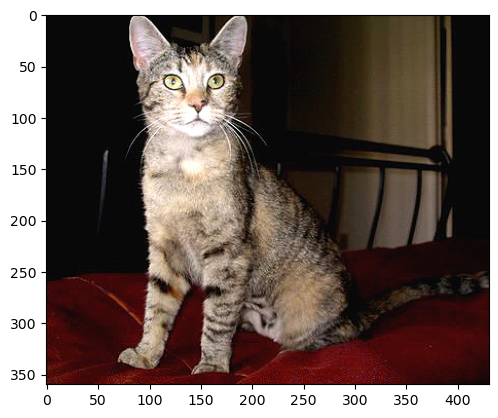

In [4]:
import matplotlib.pyplot as plt

plt.imshow(sample[0].permute([1,2,0]))

Unser Sample ist also eine Katze! Jetzt wissen wir auch, dass das `ImageFolder` Dataset Katzen mit dem Label `0`, und Hunde mit dem Label `1` versieht.  

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Ändere die `sample_id` und führe die oberen Notebook-Cells erneut aus (Zur Erinnerung: `Cmd/Ctrl+Enter` oder `Shift+Enter`), um dir noch ein paar weitere Samples ausgeben zu lassen. Was unterscheidet sich von Sample zu Sample? Wie könnte dieser Unterschied für unser Modell später zum Problem werden? 

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Anstatt die `ImageFolder`-Klasse zu verwenden, implementiere deine eigene `Dataset` Subklasse um die Bilder und Labels zu laden. Nimm dir hierzu Inspiration am folgenden Guide: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files und nutze Python's `os`-Library, zum Beispiel die Funktion `os.walk()` (https://docs.python.org/3/library/os.html#os.walk).

### Pre-Processing

Wie du bereits bemerkt hast, haben unsere Bilder unterschiedliche Größen. Da wir aber mehrere Bilder zu einem "Batch" zusammenfassen und als gemeinsamer Tensor durch unser Model schicken werden, müssen wir ihre Größe zuerst auf einen gemeinsamen Nenner bringen. Dazu haben wir mehrere Möglichkeiten, die üblichsten sind jedoch die folgenden:
- Skalierung: Hier "dehnen" oder "stauchen" wir das Bild in die gewünschte Größe. Das Resultat sieht für Menschen oft verzerrt aus.
- Padding: Hier erhalten wir das Seitenverhältnis des Original-Bildes, und füllen die Ränder mit schwarzen Pixeln auf, um das Ziel-Seitenverhältnis zu erhalten.

Wir werden die erste Methode wählen, um unsere Bilder auf die einheitliche Größe $224 \times 224$ zu skalieren. Dazu verwenden wir den `Resize`-Transform aus der `torchvision`-Library. Da CNN-Modelle Inputs in der Range $[-1,1]$ erwarten, müssen wir außerdem noch die Werte in unseren Bild-Tensors von $[0,1]$ in diese Range konvertieren. Hierzu können wir den `Normalize`-Transform nutzen. Da unser `ImageFolder` nur einen `transform`-Parameter hat, kombinieren wir die Transformationen mittels `Compose` um sie der Reihe nach auszuführen: 

In [5]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=transform)

Der "Cats-vs-Dogs" Datensatz legt uns noch ein paar weitere Stöcke vor die Füße: Die `Cats` und `Dogs` Ordner enthalten jeweils ein `Thumbs.db`-File, welches wir natürlich nicht als Bilder in unseren Datensatz aufnehmen wollen. Außerdem sind manche Bilder im Datensatz fehlerhaft und 0kb groß, diese wollen wir entsprechend auch filtern. Um beides zu erreichen, können wir unserem `ImageFolder` eine Funktion als `is_valid_file` Parameter übergeben, die beim Initialisieren des Datensatzes für jedes File im Ordner aufgerufen wird, um festzustellen, ob das File in den Datensatz aufgenommen werden soll. Wir erstellen also eine `validate_image` Funktion, die genau unsere zwei erwähnte Probleme überprüft.

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Prinzipiell könnten wir in der `validate_image` Funktion einfach versuchen, das Bild unter dem übergebenen Pfad zu laden, und `False` zurückgeben, wenn dabei ein Fehler auftritt. Warum sollten wir diesen Ansatz - wenn möglich - vermeiden?

In [6]:
import os

def validate_image(src):
    return os.path.getsize(src) > 0 and src.endswith(".jpg")

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=transform, is_valid_file=validate_image)

Fast geschafft! Als letzten Schritt müssen wir unsere Daten jetzt noch auf 3 Sets aufteilen: 
- Training-Set: enthält die Daten, mit dem wir unser Modell trainieren
- Validation-Set: enthält die Daten, mit dem wir die Performance unseres Modells beim Training einschätzen und Optimierungen machen
- Test-Set: heben wir bis ganz zum Schluss auf, um die finale Performance unseres Modells einschätzen zu können

Für die Größenverhältnisse der Sets gibt es keine harte Regel, eine häufige Aufteilung ist 60%/20%/20%. Mit der `random_split`-Funktion können wir unser `Dataset` in drei `Dataset`s aufteilen.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Abgesehen von der einmaligen Spaltung des Datensatzes in die oben genannten Sets gibt eine Reihe an aufwendigeren Techniken, um einen Datensatz für Training & Validierung aufzuteilen. Diese fallen meistens unter den Namen "Cross-Validation", und werden im folgenden Artikel gut erklärt: https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right. 

In [7]:
import torch
from torch.utils.data import random_split


generator = torch.Generator().manual_seed(42)
catsvsdogs_train, catsvsdogs_val, catsvsdogs_test = random_split(catsvsdogs_dataset, [0.6, 0.2, 0.2], generator=generator)

## Unser Erstes Model

Nachdem wir unsere Daten vorbereitet haben, ist es nun endlich Zeit, unser Model zu bauen! Wir bauen ein Convolutional Neural Network (CNN), eine Architektur, die sich als sehr performant für die Arbeit mit Bildern herausgestellt hat. Wie viele Neural Network Architekturen ist ein CNN in Layern aufgebaut, bei denen der Output des vorangehenden Layers den Input des nächsten Layers darstellt. Dementsprechend sind die Inputs und Outputs aller Layer Tensors: Der Input des ersten Layers ist der $B \times 3 \times 224 \times 224$ Tensor unseres Bildes, der Output des letzten Layers ist ein $B \times 2$ Tensor. $B$ ist hierbei die "Batch-Size", also die Anzahl an Samples, die wir gleichzeitig durch das Model schicken, bevor wir mit Backpropagation die Weights des Models anpassen. Pro Input-Bild im Batch enthält der finale Output 2 Zahlen, die zusammen immer $1$ ergeben. Diese Zahlen können als die Wahrscheinlichkeiten gesehen werden, mit denen unser Model die Tatasche einstuft, dass es sich bei dem Bild um eine Katze (Label `0`, also die erste Zahl) oder einen Hund (Label `1`, also die zweite Zahl) handelt (wenn z.B. das Model für ein Bild die Zahlen `[0.95, 0.05]` zurückgibt, ist es ziemlich sicher, dass das Bild eine Katze zeigt). 

Wie kommen wir nun von einem $B \times 3 \times 224 \times 224$ Tensor zu einem $B \times 2$ Tensor? Das folgende Bild gibt einen schematischen Überblick (Bild-Quelle: https://de.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html):

<img src="https://i.imgur.com/W2VSgRB.jpg" style="width: 700px; height: auto" title="source: imgur.com" />

Keine Sorge, im folgenden besprechen wir die einzelnen Layer-Typen des Models im Detail.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Der optimale Wert für die Batch-Size beim Training von einem Model ist von einer Reihe an Faktoren abhängig, unter anderem auch von der Menge an GPU Speicher, der mit den Bilddaten des Batches befüllt werden kann. Je nach Wahl des Optimizers, den wir zum Anpassen der Model-Weights verwenden, kann es auch nötig sein, die Learning Rate anzupassen, wenn die Batch Size geändert wird: https://www.baeldung.com/cs/learning-rate-batch-size. Wir werden den Adam-Optimizer verwenden, bei dem dies nicht nötig ist. 

### Die Layer eines CNN

#### Convolutional Layer
Wie der Name bereits vermuten lässt, sind Convolutional Layer der Kern eines CNNs. Ein Convolutional Layer besteht aus einem oder mehreren "Filtern". Jeder Filter ist ein $C \times K \times K$ Tensor an Weights (also `float`-Zahlen, die während des Trainings des Modells angepasst werden), wobei $C$ die Anzahl an Channels des Input-Layers (also z.B. $3$ für den ersten Convolutional Layer, der den $3 \times 224 \times 224$ Tensor unseres Input-Bildes als Input hat), und $K$ die sogenannte "Kernel-Size", also einfach die Größe des Filters, ist. Jeder Filter wird schrittweise über den Input-Tensor bewegt, und in jedem Schritt werden die Werte des Input-Tensors mit denen des Filters multipliziert und aufsummiert, um einen Wert im Output Tensor zu bestimmen (Bild-Quelle: https://medium.datadriveninvestor.com/convolutional-neural-networks-3b241a5da51e): 

<img src="https://i.imgur.com/5U0iCFK.gif" style="width: 600px; height: auto;" title="source: imgur.com" />


Jeder Filter erzeugt somit einen Channel im Output. Wir können uns also vorstellen, dass jeder Filter lernt, ein bestimmtes Muster in $K \times K$ Regionen seines Inputs zu erkennen, und ein Channel im Output eines Convolutional Layers den Grad angibt, zu dem dieses Muster in den unterschiedlichen Regionen des Inputs erkannt wurde. Wenn wir Convolutional Layer übereinander stapeln, die Outputs der Filter des ersten Layers also zum Input der Filter des nächsten werden, werden die erkannten Muster der höheren Layer immer und immer komplexer. Die Filter des ersten Convolution Layers könnten also z.B. lernen, simple Farbverläufe oder Kanten zu erkennen, während die Filter höherer Layer Dinge wie Augen oder Felltextur erkennen.  

In PyTorch kann ein Convolutional Layer mit der `Conv2d`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html. Wir verwenden ein `padding` von `"same"`, womit dem Input so zusätzliche $0$-Reihen und -Spalten hinzugefügt werden, dass die $H$ und $W$ Dimensionen des Inputs und Outputs gleich bleiben (Bild-Quelle: Wikimedia Commons):

<img src="https://i.imgur.com/8MJ5T9S.gif" style="width: 300px; height: auto" title="source: imgur.com" />


#### ReLU Activation Function
Zu diesem Zeitpunkt stellen die Outputs unserer CNN-Layer eine lineare Kombination ihrer Input-Werte dar. Wer sich schon einmal mit linearer Regression beschäftigt hat wird wissen, dass die Art von Beziehungen zwischen Input und Output, die nur mit linearer Kombination darstellbar ist, sehr eingeschränkt ist. Wir müssen also eine Art von Non-Linearität in unser Modell bringen, wofür wir eine sogenannte Activation Function nutzen: diese wird einfach einzeln auf jedes Element des Output-Tensors des vorherigen Layers angewandt. Wir verwenden die ReLU Activation Function, die wie folgt aussieht: 


In PyTorch kann ein ReLU Layer mit der `ReLU`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html. Wir ordnen diese immer nach einem Convolutional Layer an.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Die ReLU Funktion wird eingesetzt, um das [Vanishing Gradient Problem](https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html) zu bekämpfen, das beim Trainieren von vielschichtigen Modellen mit den zuvor populären Sigmoid und TanH Activation Functions auftritt. Sie ist jedoch bei weitem nicht die einzige Option. Eine Übersicht über andere Activation Functions findest du hier: https://en.wikipedia.org/wiki/Activation_function. 

#### Max Pooling Layer 
Um die $H$ und $W$ Dimensionen des Inputs zu verringern, verwenden wir Pooling Layer. Diese fassen einfach pro Channel eine Gruppe an nebeneinander liegenden Inputs zusammen. Die populärsten Arten von Pooling sind Max und Average Pooling. Verwenden wir beispielsweise Max Pooling mit einer Kernel Size von $2$, und der Input unseres Max Pooling Layers hat die Dimensionen $C \times H \times W$, wird der Output die Dimensionen $C \times H/2 \times W/2$ haben, wobei jeder Eintrag das Maximum eines $2\times2$ Rechtecks im Input darstellt. 

Warum würden wir das tun wollen? Erstens, um die Größe unseres Input-Tensors über das Modell hinweg schrittweise zu verkleinern. Zweitens, um das Modell weniger anfällig für die genaue Position eines erkannten Musters zu machen, indem wir nebeneinander liegende Muster-Erkennungen zusammenfassen.

In PyTorch kann ein Max Pooling Layer mit der `MaxPool2d`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html. Gewöhnlich ordnen wir Pooling Layer nach der Activation Function eines Convolutional Layers an. 

#### Flattening Layer
Nach einem Stapel an Convolutional-Activation-Pooling Layern, die alle die 3-dimensionale $C \times H \times W$ Struktur unseres Bild-Inputs beibehalten, brauchen wir einen Layer, der diese in die 1-dimensionale Struktur unseres finalen Outputs umwandelt. Ein Flattening Layer tut genau das: Er hat als Input einen $B \times C \times H \times W$ Tensor, und gibt als Output einen $B \times (C \cdot H \cdot W)$ Tensor zurück. 

In PyTorch wird dieser Layer mit der `Flatten`-Klasse erstellt: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html. 

#### Fully Connected Layer
Um den $B \times (C \cdot H \cdot W)$ Output unseres Flattening Layers auf unseren finalen $B \times 2$ Output zu reduzieren, bauen wir ein paar Fully Connected Layer ein. Diese sind die ganz klassischen Neural Network Layer: Jeder Layer besteht aus $N$ Neuronen, die mit allen $M$ Neuronen des vorhergehenden Layers verbunden sind. Pro Sample im Batch wird in jedem Neuron der Output der $M$ Vorgänger mit einem anderen Weight multipliziert, und zusammenaddiert (inkl. einem Bias-Weight), um den Output des Neurons zu bestimmen. Aus einem $B \times M$ Input wird somit ein $B \times N$ Output. 

In PyTorch wird dieser Layer mit der `Linear`-Klasse erstellt: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html. Wie bei den Convolutional Layers ordnen wir hinter jedem Fully Connected Layer eine ReLU Activation Function an.

#### Softmax Layer
Mit einem oder mehreren Fully Connected Layern können wir unseren Output auf $B \times 2$ Dimensionen reduzieren. Pro Sample im Batch können die 2 resultierenden Zahlen jedoch jeden beliebigen Wert von $- \infty$ bis $+\infty$ haben. Um diese in Wahrscheinlichkeiten umzuwandeln, die auf $1$ aufsummieren, verwenden wir die [Softmax Activation Function](https://en.wikipedia.org/wiki/Softmax_function). 

In PyTorch können wir einen Softmax-Layer mit der `Softmax`-Klasse erstellen: https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html. Unser Input für den Softmax-Layer wird das Format $B \times 2$ haben, und wir wollen, dass die Werte pro Sample auf $1$ summieren, somit geben wir als `dim` den Wert `1` an (die Dimensions-Indizes starten bei 0). 




### Das Model 
Nach dieser Flut an Erklärungen können wir endlich unser Model bauen, uns fehlt aber noch die genaue Konfiguration und die Anordnung der einzelnen Layer. Hier orientieren wir uns am VGG16 Model, welches 2014 für ImageNet vorgeschlagen wurde (ein Datensatz an >14 Millionen Bildern, die in 1.000 verschiedene Klassen eingeteilt sind), und damals State-of-the-Art Performance lieferte. Das Model wird im folgenden Paper näher erläutert: https://arxiv.org/abs/1409.1556, wir richten uns aber an dieser übersichtlicheren Grafik (Quelle: https://www.nature.com/articles/s41529-018-0058-x): 

<img src="https://i.imgur.com/S468nnF.png" style="width: 600px; height: auto;" title="source: imgur.com" />

Um die Anzahl an Weights des Modells klein zu halten und das Training zu beschleunigen, treffen wir ein paar Anpassungen:
- Statt mehreren ident konfigurierten Convolutional Layern zwischen den Pooling Layern verwenden wir immer nur einen. Für diese Convolutional Layer verwenden wir immer eine Kernel-Size von $3 \times 3$.
- Statt $4096$ verpassen wir den ersten zwei Fully-Connected Layern nur $512$ und $128$ Neurons.
- Da wir nur zwischen 2 Klassen unterscheiden wollen, hat der dritte Fully-Connected Layer nur $2$ und nicht $1000$ Neurons.

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Nutze die `Sequential` Funktion von PyTorch (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), um das VGG 16 Model mit den erwähnten Modifikationen in der nächsten Notebook-Cell nachzubauen. Du benötigst ausschließlich die Layer-Typen, die vorher besprochen wurden. Falls du anstehst, klappe die Referenzlösung in der übernächsten Notebook-Cell aus. 

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Um kompliziertere Model-Strukturen abzubilden, können PyTorch Models auch als Subklasse der `Module`-Klasse gebaut werden. Orientiere dich an folgendem Guide, um das VGG 16 Model auf diese Art zu konstruieren: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network. Du kannst ebenfalls die [funktionalen Varianten](https://pytorch.org/docs/stable/nn.functional.html) jener Layer verwenden, die keine trainierbaren Weights enthalten (also alle außer der Convolutional und Fully-Connected Layer).

In [8]:
import torch.nn as nn

def build_catsvsdogs_model():
    return nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        # Ergänze die restlichen Layer
        nn.Linear(128, 2),
        nn.Softmax(dim=1)
    )

catsvsdogs_model = build_catsvsdogs_model()

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Referenz-Lösung
def build_catsvsdogs_model():
    return nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(256, 512, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(512, 512, kernel_size=(3,3), padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(512 * 7 * 7, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 2),
        nn.Softmax(dim=1)
    )

catsvsdogs_model = build_catsvsdogs_model()

Da wir das Model auf der GPU laufen lassen wollen, müssen wir es zuerst dorthin kopieren. Das geht mit PyTorch sehr einfach, nämlich mit der Methode `.to()`. Haben wir nur eine Nvidia-Grafikkarte im System, ist diese unter dem Namen `"cuda"` verfügbar.

In [10]:
catsvsdogs_model = catsvsdogs_model.to("cuda")

Ob wir unsere Layer richtig konfiguriert haben, sehen wir mit der `summary()` Funktion der `torchinfo`-Library. Diese gibt uns eine Übersicht über die Layer unseres Modells und die Anzahl an Weights (Params) pro Layer:

In [11]:
from torchinfo import summary
import torch

print(summary(catsvsdogs_model, input_size=(16, 3, 224, 224), device="cuda"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 224, 224]        1,792
├─ReLU: 1-2                              [16, 64, 224, 224]        --
├─MaxPool2d: 1-3                         [16, 64, 112, 112]        --
├─Conv2d: 1-4                            [16, 128, 112, 112]       73,856
├─ReLU: 1-5                              [16, 128, 112, 112]       --
├─MaxPool2d: 1-6                         [16, 128, 56, 56]         --
├─Conv2d: 1-7                            [16, 256, 56, 56]         295,168
├─ReLU: 1-8                              [16, 256, 56, 56]         --
├─MaxPool2d: 1-9                         [16, 256, 28, 28]         --
├─Conv2d: 1-10                           [16, 512, 28, 28]         1,180,160
├─ReLU: 1-11                             [16, 512, 28, 28]         --
├─MaxPool2d: 1-12                        [16, 512, 14, 14]        

## Training

Wir haben unsere Daten, wir haben unser Model, Zeit für Training! Dieses läuft in einem Loop ab, der folgende Schritte hat:
1. Wir laden die Samples unseres Training-Sets in zufälliger Reihenfolge in Batches, z.B. zu je $B=64$ Samples
2. Wir schicken einen Batch durch unser Model, und erhalten die Outputs für den Batch (wie oben beschreiben, ein Tensor im Format $B \times 2$)
3. Wir nutzen die Outputs und die echten Labels der Samples im Batch als Inputs für eine "Loss-Function". Diese beschreibt uns, wie gut oder schlecht die Vorhersagen des Models für den aktuellen Batch waren (je höher der Loss, desto schlechter die Performance). Für Klassifizierung ist `CrossEntropyLoss` die richtige Wahl: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
4. Mit Aufruf der `.backward()` Funktion am `loss`-Output der Loss-Function lösen wir Backpropagation aus: über partielle Ableitungen bestimmt PyTorch jetzt für jedes Weight in den Model-Layern, wie sehr und in welche Richtung es sich ändern müsste, um den Loss für den aktuellen Batch zu minimieren (die sogenannten Gradients). 
5. Würden wir jetzt exakt diese Änderungen durchführen, würde wir unser Model perfekt an den aktuellen Batch anpassen. Da dieser aber kaum eine vollständige Repräsentation aller möglichen Inputs darstellt, würden wir "über das Ziel hinaus schießen". Stattdessen nähern wir uns in kleinen Schritten, bestimmt durch die sogenannte Learning Rate. Anpassungen dieser Learning Rate sind der Job des sogenannten Optimizers. Wir verwenden den `Adam` Optimizer. Über Aufruf der `.step()` Funktion am Optimizer passen wir tatsächlich die Weights im Model anhand der Gradients an (auch Gradient Descent genannt)
6. Haben wir alle Trainingsdaten einmal so verwendet, deaktivieren wir die Berechnung von Gradients (mittels `torch.no_grad()`) und evaluieren das Model am Validation-Set. Da das Model diese Daten im Training nie gesehen hat, gibt uns das einen guten Indikator für die tatsächliche Performance des Models.
7. Wir haben nun eine sogenannte Epoch abgeschlossen, und beginnen den Prozess erneut bei Schritt 1. Je nach Modell, Datenmenge, usw., wiederholen wir den Prozess für mehrere oder gar mehrere Dutzend Epochs. 

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Eine sehr detaillierte Erklärung von Back-Propagation findest du hier: http://neuralnetworksanddeeplearning.com/chap2.html. Dieses Video erläutert erläutert den Prozess sehr anschaulich: https://www.youtube.com/watch?v=tIeHLnjs5U8.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> PyTorch hat einen speziellen Mechanismus zur Berechnung von Gradients, Autograd. Für diesen gibt es hier eine oberflächliche Einführung: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html. 

Bringen wir also die einzelnen Komponenten unseres Training-Loops zusammen. Zuerst brauchen wir eine Möglichkeit, die Samples unseres `Dataset`s in Batches zu laden. Hierfür hat PyTorch die `DataLoader`-Klasse:

In [12]:
training_loader = torch.utils.data.DataLoader(catsvsdogs_train, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)
validation_loader = torch.utils.data.DataLoader(catsvsdogs_val, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)

Als nächstes brauchen wir unsere Loss Function und unseren Optimizer. Wie bereits erwähnt verwenden wir `CrossEntropyLoss` und den `Adam` Optimizer.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Welche Learning-Rate sollen wir verwenden? Diese Frage ist nicht allgemein zu beantworten, sondern Teil des sogenannten Hyperparameter-Tunings (als das Optimieren jener Parameter, die nicht direkt Teil des Models sind - also dessen Weights - sondern das Training und die Zusammenstellung des Models selbst beeinflussen). Dieses kann entweder manuell via Trial-and-Error durchgeführt werden, [es gibt aber auch automatisierte Ansätze](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html#hyperparameter-tuning-with-ray-tune). Wenn die Learning Rate zu hoch ist, passt werden die Model-Weights zu sehr an die Besonderheiten des aktuellen Batches angepasst, das Training "überschießt das Ziel". Dies macht sich meist darin bemerkbar, dass der Loss über viele Batches hinweg gleich bleibt oder oft nach ein paar Batches plötzlich wieder steigt. Ist die Learning Rate zu niedrig, verbessert sich der Loss zwar mit der Zeit, aber viel zu langsam.

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(catsvsdogs_model.parameters(), lr=0.00005)

Als nächstes definieren wir eine Funktion, die eine Epoch an Training durchführt, also Schritte 1-5 durchläuft. Wir lassen uns alle 10 Epochs den durchschnittlichen Loss ausgeben, um ein Gefühl für den Fortschritt des Trainings zu bekommen. Da der Loss alleine für uns aber wenig aussagt, lassen wir uns zusätzlich noch mit der `accuracy_score` Funktion der `sklearn`-Library die durchschnittliche Accuracy ausgeben, also wie viel Prozent der Samples in den Batches korrekt klassifiziert wurden. 

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> In unserem Fall sind unsere Daten genau 50-50 auf unsere beiden Klassen aufgeteilt. Was für ein Problem entsteht mit der Accuracy-Metrik, wenn dies nicht der Fall ist? Denke an die Accuracy eines Modells, das bei jedem Input-Sample einfach nur wie mit einem Münzwurf die Klasse errät. Welche Accuracy würde hier entstehen, wenn die Daten z.B. 80-20 auf die Klassen aufgeteilt wären? 

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Füge der Methode noch zwei weitere beliebte Metriken hinzu, [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) und [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score). Hier findest du eine gute Erklärung der beiden Metriken: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html. 

In [14]:
from sklearn.metrics import accuracy_score

def train_one_epoch(model, training_loader, optimizer, loss_fn):
    running_loss = 0.
    running_accuracy = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data[0].to("cuda"), data[1].to("cuda")

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(data[1], outputs.argmax(dim=-1).cpu())
        if i % 10 == 9:
            last_loss = running_loss / 10
            last_accuracy = running_accuracy / 10
            print('  batch {} loss: {:.6f} accuracy: {:.4f}%'.format(i + 1, last_loss, last_accuracy))
            running_loss = 0.
            running_accuracy = 0.
            
        del inputs, labels, loss

    return last_loss, last_accuracy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Als nächstes definieren wir uns eine kleine Funktion, die das Model am Validation-Set evaluiert. Die Funktion verwendet `torch.no_grad()` um das Gradient-Tracking zu deaktivieren.

In [15]:
def validate(model, validation_loader):
    running_vloss = 0.0
    running_vaccuracy = 0.0

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to("cuda"), vdata[1].to("cuda")
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            vaccuracy = accuracy_score(vdata[1], voutputs.argmax(dim=-1).cpu())
            running_vloss += vloss
            running_vaccuracy += vaccuracy
    
    avg_vloss = running_vloss / (i + 1)
    avg_vaccuracy = running_vaccuracy / (i + 1)

    print('Validation LOSS {:.6f} ACCURACY {:.4f}%'.format(avg_vloss, avg_vaccuracy))
    return avg_vloss, avg_vaccuracy


Die einzige Komponente, die uns jetzt noch bleibt, ist eine `train()`-Funktion, die Schritte 1-7 über mehrere Epochs hinweg durchführt. Die Funktion speichert zudem nach jeder Epoch das Model, wenn der durchschnittliche Loss am Validation-Set niedriger als in allen bisherigen Epochs ist.

In [16]:
from datetime import datetime


def train(model, training_loader, validation_loader, optimizer, loss_fn, epochs=5, model_name="model"):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    epoch_number = 0
    best_vloss = 1_000_000.
    
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        model.train(True)
        last_training_loss, last_training_accuracy = train_one_epoch(model, training_loader, optimizer, loss_fn)
        print('Last Training LOSS {:.6f} ACCURACY {:.4f}%'.format(last_training_loss, last_training_accuracy))

        model.eval()
        avg_vloss, _ = validate(model, validation_loader)

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = '{}_{}_{}'.format(model_name, timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

Endlich haben wir alles beisammen, das Training kann beginnen!

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Trainiere das Model für 10 Epochs (~20 Minuten). Beobachte dabei die Entwicklung von Loss und Accuracy, sowohl am Train als auch am Validation Set? Divergieren die Werte für die beiden Sets?

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Experimentiere mit der Learning Rate des `Adam` Optimizers. Was passiert, wenn du die Learning Rate viel höher / viel niedriger stellst?

In [17]:
train(catsvsdogs_model, training_loader, validation_loader, optimizer, loss_fn, epochs=10)

EPOCH 1:
  batch 10 loss: 0.692374 accuracy: 0.5141%
  batch 20 loss: 0.694322 accuracy: 0.4766%
  batch 30 loss: 0.692057 accuracy: 0.5156%
  batch 40 loss: 0.693532 accuracy: 0.4844%
  batch 50 loss: 0.691188 accuracy: 0.5578%
  batch 60 loss: 0.689361 accuracy: 0.5281%
  batch 70 loss: 0.676463 accuracy: 0.6000%
  batch 80 loss: 0.669134 accuracy: 0.5906%


KeyboardInterrupt: 

## Overfitting

Das Training hat ein brauchbares Model produziert, wie du aber sicher schon bemerkt hast mit einem Catch: Nach einigen Epochs ist der Loss und die Accuracy am Trainings-Set zwar weiter gesunken, die entsprechenden Werte am Validation-Set jedoch nicht. Unser Model hat also begonnen, Spezifika des Training-Sets zu lernen, die sich nicht neue Daten (also unser Validation-Set) übertragen lassen: wir sprechen hier von Overfitting. 

Um Overfitting zu bekämpfen gibt es eine Reihe an Techniken, unter anderem:

**Early Stopping**  
Die Idee hinter Early Stopping ist simpel: Unser Model kann nicht overfitten, wenn wir das Training stoppen, sobald wir overfitting erkennen! Dieser Ansatz hat jedoch einige Probleme: Erstens ist es nicht sofort offensichtlich, wann das Training wegen Overfitting abgebrochen werden sollte: Nach einer Epoch, in der sich der Loss am Validation-Set nicht verbessert? Dies würde zum Beispiel das Risiko mit sich ziehen, das Training wegen einer Ausreißer-Epoch verfrüht abzubrechen. Zweitens verbessert dieser Ansatz nicht das Level an Performance, die das Model am Validation-Set erreichen kann, er verhindert nur die Verschwendung von Compute-Ressourcen, sobald dieses Level erreicht ist.


**Ensembling**  
Ensembling basiert auf der Idee von Gruppenintelligenz: Wenn ein Model sich auf bestimmte Spezifika des Training-Sets einschießt, trainieren wir doch mehrere, und kombinieren deren Resultate! Da schon ein einzelnes Deep Learning Model zu trainieren meist sehr leistungsintensiv ist, wird diese Technik hauptsächlich bei "klassischen" ML Methoden angewandt, zum Beispiel bei [Random Forests](https://en.wikipedia.org/wiki/Random_forest), einem Ensemble aus Decision Trees.

**Regularization**  
Unter Regularization fallen eine Reihe an Techniken, die alle darauf abzielen, die Freiheitsgrade eines Models einzuschränken, hierunter fallen unter anderem:
- Weight Decay: Hier wird der Loss-Function ein Term hinzugefügt, der auf eine bestimmte Art die Summe der Model Weights repräsentiert. Da das Ziel des Trainings ist, die Model Weights so anzupassen, dass die Loss-Function minimiert wird, werden durch diesen Term die Model Weights tendenziell kleiner gehalten. 
- Dropout: Ein Dropout Layer setzt beim Training zufällig einen bestimmten Prozentsatz seiner Inputs auf `0`. Dadurch kann sich der darauffolgende Layer nicht zu sehr auf bestimmte Inputs verlassen.
- Batch Normalization: Ein Batch-Normalization Layer standardisiert seine Inputs über einen Batch hinweg, von jedem Input wird also der Mittelwert dieses Inputs im Batch abgezogen, und der resultierende Wert durch die Standardabweichung dieses Inputs im Batch dividiert. Dies sorgt dafür, dass die Inputs des darauffolgenden Layers über mehrere Batches hinweg eine einheitliche Form annehmen.

**Feature Selection & Dimensionality Reduction**  
Wenn unser Model sich auf Details im Training-Set einschießen kann, haben unsere Inputs vielleicht einfach zu viel Detail. Die Idee hinter Feature Selection ist es, die relevantesten Input-Dimensionen herauszufiltern, während Dimensionality Reduction zum Ziel hat, stark korrelierende Input-Dimensionen zu einem neuen Input zusammenzufassen.

**Größere Datenmengen**  
Wenn unsere Trainings-Daten nicht ausreichen, um dem Model alle Sonderfälle der aktuellen Aufgabenstellung zu vermitteln, kann eine Lösung sein, mehr Daten zu beschaffen. Je nach Aufgabenstellung ist es aber alles andere als einfach, neue Daten zu organisieren: beispielsweise im medizinischen Bereich dauert es oft Jahre, um genug Freiwillige zu finden, die ihre CT-Scans, Röntgenbilder, usw. für ein Forschungsprojekt freigeben.  

**Data Augmentation**  
Unter anderem wenn das Beschaffen neuer Daten nicht möglich oder zu teuer ist, liefert Data Augmentation eine Alternative: wir transformieren die bestehenden Daten, um das Model zu zwingen, sich auf die essentiellen Eigenschaften der unterschiedlichen Samples zu fokussieren. Die Intuition ist simpel: Ein auf den Kopf gestelltes oder rotiertes Bild eines Hundes zeigt immer noch einen Hund. Ein Katze ist immer noch als Katze erkennbar, egal ob sie im oberen linken Eck oder in der Mitte des Bildes platziert ist. Durch solche oft einfach umsetzbaren Variationen verleiten wir das Model dazu, seine Entscheidungen nicht auf Basis von Biases in den Trainings-Daten zu treffen (z.B. Hunde sind tendenziell links im Bild, Bilder von Katzen sind schlechter beleuchtet). 

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Die meisten der oben kurz beschriebenen Techniken werden im folgenden Buch mit mehr Detail behandelt: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/.

## Data Augmentation
Wir verwenden heute Data Augmentation, um das Overfitting unseres Models zu bekämpfen. Dazu erweitern wir den `transform`, den wir unserem `Dataset` übergeben haben, mit einer Reihe an zufällig agierenden Transforms aus `torchvision`-Library. Da wir diese Transforms nur für das Trainings-Set verwenden wollen, müssen wir die angewandten Transforms für Training und Validation aufteilen.

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Füge dem `transform_train`-Objekt in der nächsten Notebook-Cell einige zufällige Transforms aus der `torchvision`-Library (https://pytorch.org/vision/stable/transforms.html) hinzu, zum Beispiel `RandomRotation`, `RandomHorizontalFlip`, und `RandomResizedCrop`. Achte beim `RandomResizedCrop` darauf, dass die `size` weiterhin `(224,224)` ist, damit sich die Input-Größe unseres Models nicht ändert. Falls du hier nicht experimentieren willst, übernimm die Konfiguration in der eingeklappten Notebook-Cell darunter.

In [18]:
transform_train = transforms.Compose([
    # Füge hier deine zufälligen Transforms hinzu
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
transform_train = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((224,224), (0.7,1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Da wir jetzt unterschiedliche transforms für Training und Validation haben, können wir keinen Transform direkt an die `ImageFolder`-Klasse übergeben. Stattdessen basteln wir uns eine Wrapper `Dataset`-Klasse, die Samples eines darunterliegenden `Dataset`s zurückgibt, sie aber vorher mit einem Transform verändert. 

In [26]:
from torch.utils.data import Dataset

class LazyTransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            features = self.transform(self.dataset[index][0])
        else:
            features = self.dataset[index][0]
        label = self.dataset[index][1]
        return features, label
    
    def __len__(self):
        return len(self.dataset)
    


catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", is_valid_file=validate_image)

generator = torch.Generator().manual_seed(42)
catsvsdogs_train_raw, catsvsdogs_val_raw, catsvsdogs_test_raw = random_split(catsvsdogs_dataset, [0.6, 0.2, 0.2], generator=generator)
catsvsdogs_train_augmented = LazyTransformDataset(catsvsdogs_train_raw, transform=transform_train)
catsvsdogs_val_augmented = LazyTransformDataset(catsvsdogs_val_raw, transform=transform_val)

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Sehen wir uns jetzt einige der transformierten Bilder and. Passe die Parameter der Transformationen an, falls dir einer der Effekte zu extrem erscheint.

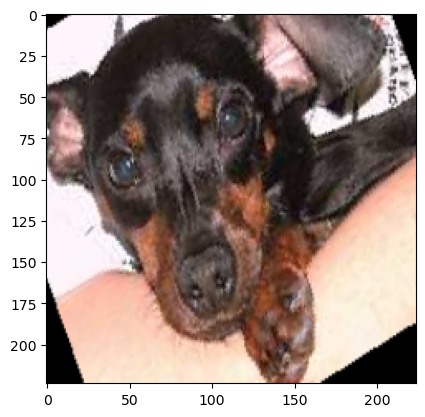

In [27]:
sample_id = 10
sample = catsvsdogs_train_augmented.__getitem__(sample_id)

plt.imshow(sample[0].permute([1,2,0]) / 2 + 0.5)

Da wir nun neue Datasets haben, müssen wir entsprechend auch unsere `DataLoader` neu definieren.

In [28]:
training_loader_augmented = torch.utils.data.DataLoader(catsvsdogs_train_augmented, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)
validation_loader_augmented = torch.utils.data.DataLoader(catsvsdogs_val_augmented, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)

Außerdem erstellen wir eine neue Instanz unseres Models und des Optimizers, da wir das Model von Grund auf neu trainieren wollen.

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Experimentiere mit dem `weight_decay` Parameter des Optimizers, der sogenannte L2-Regularization anwendet. Eine kompakte Erklärung von L2-Regularization findest du hier: https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization. Kannst du damit die Performance des Models noch weiter steigern, also mit Data Augmentation allein? 

In [29]:
catsvsdogs_model_augmented = build_catsvsdogs_model().to("cuda")
optimizer_augmented = torch.optim.Adam(catsvsdogs_model_augmented.parameters(), lr=0.00005)

Wir haben also wieder alles beisammen, um unser Model mit augmented Daten zu trainieren.

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Beobachte das Training des neuen Models. Erreichen wir eine bessere finale Accuracy? Tritt immer noch Overfitting auf?

In [30]:
train(catsvsdogs_model_augmented, training_loader_augmented, validation_loader_augmented, optimizer_augmented, loss_fn, epochs=10)

EPOCH 1:
  batch 10 loss: 0.693887 accuracy: 0.4875%
  batch 20 loss: 0.693067 accuracy: 0.5031%
  batch 30 loss: 0.692953 accuracy: 0.5062%
  batch 40 loss: 0.692806 accuracy: 0.5047%
  batch 50 loss: 0.690196 accuracy: 0.5703%
  batch 60 loss: 0.691894 accuracy: 0.5156%
  batch 70 loss: 0.689480 accuracy: 0.5672%
  batch 80 loss: 0.686898 accuracy: 0.5359%
  batch 90 loss: 0.670698 accuracy: 0.5859%
  batch 100 loss: 0.685806 accuracy: 0.5625%
  batch 110 loss: 0.657363 accuracy: 0.6266%
  batch 120 loss: 0.660027 accuracy: 0.6125%
  batch 130 loss: 0.669043 accuracy: 0.5734%
  batch 140 loss: 0.661544 accuracy: 0.6094%
  batch 150 loss: 0.657992 accuracy: 0.6062%
  batch 160 loss: 0.640778 accuracy: 0.6375%
  batch 170 loss: 0.648681 accuracy: 0.6234%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 180 loss: 0.667941 accuracy: 0.5844%
  batch 190 loss: 0.639589 accuracy: 0.6578%
  batch 200 loss: 0.641733 accuracy: 0.6031%
  batch 210 loss: 0.663520 accuracy: 0.5922%
  batch 220 loss: 0.634635 accuracy: 0.6547%
  batch 230 loss: 0.629204 accuracy: 0.6578%
Last Training LOSS 0.629204 ACCURACY 0.6578%
Validation LOSS 0.625500 ACCURACY 0.6604%
EPOCH 2:
  batch 10 loss: 0.640695 accuracy: 0.6312%
  batch 20 loss: 0.651282 accuracy: 0.6250%


KeyboardInterrupt: 

## Transfer Learning
Warum alles selber machen, wenn man auch auf den Schultern von Giganten stehen kann? Über die letzten Jahre wurden für viele Einsatzzwecke komplexe ML-Models an immensen Datenmengen trainiert, die weit das Maß übersteigen, das wir auf handelsüblicher Hardware für Konsumenten in realistischer Zeit zum Training verwenden könnten (ein frühes Beispiel hierfür ist der bereits erwähnte [ImageNet Datensatz](https://www.image-net.org/)). Wir können aber das dadurch erlangte Grundverständnis dieser Modelle für einen bestimmten Nutzungsbereich (z.B. Bilder-Klassifizierung) nutzen, und sie an unseren spezifischen Use-Case anpassen. 

Hierfür laden wir ein bereits vortrainiertes Modell, z.B. [ResNet-50](https://arxiv.org/abs/1512.03385), für welches es zu diesem Zweck ein eigenes PyTorch-Modul gibt: `resnet50`. Dieses Modell wurde auf ImageNet trainiert und hat dementsprechend 1000 Ouput-Neurons, passend zu den 1000 unterschiedlichen Klassen im ImageNet Datensatz. Wir fügen dem Modell einige Fully-Connected Layer hinzu, um den Output auf das $B \times 2$ Format für unsere Problemstellung zu reduzieren. 



In [38]:
from torchvision.models import resnet50,ResNet50_Weights
import torch

resnet50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
catsvsdogs_model_transfer = torch.nn.Sequential(
    resnet50_model,
    torch.nn.ReLU(),
    torch.nn.Linear(1000,200),
    torch.nn.ReLU(),
    torch.nn.Linear(200,2),
    torch.nn.Softmax(dim=1)
).to("cuda")

Für das Training des Modells haben wir zwei Optionen: Entweder wir trainieren die Layer des originalen ResNet-50 Models mit (normalerweise mit einer niedrigen Learning-Rate, um das bereits gelernte Wissen des Models nicht zu zerstören), oder wir "frieren" die originalen Layer ein und trainieren nur unsere zusätzlichen Layer an den Outputs des originalen Models. Die zweite Options erspart uns die Gradient-Berechnungen für die (meist zahlreichen) Layer des originalen Models und liefert oft bereits ausreichende Ergebnisse, weswegen wir diese Option hier verfolgen werden.

Um die Layer des originalen Models einzufrieren, setzen wir den `requires_grad` Parameter der Model Weights auf `False`:

In [39]:
for param in resnet50_model.parameters():
    param.requires_grad = False

Unser Model sieht nun so aus (beachte die Differenz in der Menge an trainierbaren und nicht-trainierbaren Parametern):

In [40]:
print(summary(catsvsdogs_model_transfer, input_size=(16, 3, 224, 224), device="cuda"))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [16, 2]                   --
├─ResNet: 1-1                                 [16, 1000]                --
│    └─Conv2d: 2-1                            [16, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [16, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [16, 64, 56, 56]          --
│    └─Sequential: 2-5                        [16, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [16, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [16, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [16, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [16, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [16, 512, 28, 28]      

Mit einem neu initialisierten Optimizer lässt sich das Modell jetzt wie gewohnt trainieren:

In [41]:
optimizer_transfer = torch.optim.Adam(catsvsdogs_model_transfer.parameters(), lr=0.00002)
train(catsvsdogs_model_transfer, training_loader_augmented, validation_loader_augmented, optimizer_transfer, loss_fn, model_name="transfer", epochs=2)

EPOCH 1:
  batch 10 loss: 0.688363 accuracy: 0.5625%
  batch 20 loss: 0.674447 accuracy: 0.6469%
  batch 30 loss: 0.664754 accuracy: 0.6891%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 40 loss: 0.649805 accuracy: 0.7828%
  batch 50 loss: 0.639187 accuracy: 0.8219%
  batch 60 loss: 0.629232 accuracy: 0.8484%
  batch 70 loss: 0.615382 accuracy: 0.8812%
  batch 80 loss: 0.603401 accuracy: 0.9000%
  batch 90 loss: 0.590666 accuracy: 0.9109%
  batch 100 loss: 0.579898 accuracy: 0.9141%
  batch 110 loss: 0.562652 accuracy: 0.9453%
  batch 120 loss: 0.553898 accuracy: 0.9453%
  batch 130 loss: 0.550872 accuracy: 0.9172%
  batch 140 loss: 0.531068 accuracy: 0.9453%
  batch 150 loss: 0.527934 accuracy: 0.9391%
  batch 160 loss: 0.513117 accuracy: 0.9422%
  batch 170 loss: 0.500475 accuracy: 0.9406%
  batch 180 loss: 0.496859 accuracy: 0.9375%
  batch 190 loss: 0.484198 accuracy: 0.9563%
  batch 200 loss: 0.476721 accuracy: 0.9422%
  batch 210 loss: 0.474675 accuracy: 0.9359%
  batch 220 loss: 0.464026 accuracy: 0.9500%
  batch 230 loss: 0.470230 accuracy: 0.9313%
Last Training LOSS 0.470230 ACCURACY 0.9313%
Validation LOSS 0.451104 ACCURACY 0.9579%
EPOCH 2:
  batch 10

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 200 loss: 0.400857 accuracy: 0.9531%
  batch 210 loss: 0.399702 accuracy: 0.9625%
  batch 220 loss: 0.400078 accuracy: 0.9531%
  batch 230 loss: 0.386555 accuracy: 0.9641%
Last Training LOSS 0.386555 ACCURACY 0.9641%
Validation LOSS 0.386437 ACCURACY 0.9646%


## Ergebnis
Geschafft! Wir haben drei unterschiedliche Models zur Unterscheidung von Katzen und Hunden gebaut. Nun ist es an der Zeit, diese Models auch zu verwenden. Dazu basteln wir uns ein kleines Interface mit der `gradio`-Library (https://www.gradio.app/), das wir direkt im Notebook verwenden können. 

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Teste deine Models, am besten an Bildern deiner eigenen Haustiere! Decken sich die Performance-Unterschiede der Models am Validation-Set mit denen deiner Beispiele? Mit welchen Situationen tun sich die Models schwer? 

In [42]:
# Installiert die gradio-Library, da sie nicht von Kaggle vorinstalliert wird
!pip install gradio --quiet

In [43]:
import gradio as gr

model = catsvsdogs_model_transfer
labels = ["Cat", "Dog"]

def predict(inp):
  transformed_input = transform_val(inp).unsqueeze(0)
  with torch.no_grad():
    prediction = model(transformed_input.to("cuda"))
    print(prediction)
    confidences = {labels[i]: float(prediction[0][i]) for i in range(2)}    
  return confidences

examples = [
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/10003.jpg", 
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10037.jpg",
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/11004.jpg", 
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11064.jpg"
]

gr.Interface(fn=predict, 
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=3),
             examples=examples).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a5692fddbd3d8d7aea.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


tensor([[0.1154, 0.8846]], device='cuda:0')
tensor([[0.0941, 0.9059]], device='cuda:0')
tensor([[0.9966, 0.0034]], device='cuda:0')
tensor([[0.9274, 0.0726]], device='cuda:0')
